<a href="https://colab.research.google.com/github/ccoyso/Tapia/blob/main/C%C3%B3digo_para_Detecci%C3%B3n_de_C%C3%A1ncer_Pulmonar_con_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Importación de Bibliotecas

In [2]:
import os  # Manejo de rutas y sistema de archivos
import numpy as np  # Operaciones numéricas eficientes
import matplotlib.pyplot as plt  # Visualización de datos
from PIL import Image  # Procesamiento de imágenes
import torch  # Framework para deep learning
import torchvision  # Herramientas para visión por computadora
from torchvision import models, transforms  # Modelos preentrenados y transformaciones
import torch.nn as nn  # Bloques de construcción de redes neuronales
import torch.optim as optim  # Algoritmos de optimización
from torch.utils.data import Dataset, DataLoader, random_split  # Manejo de datasets
from sklearn.metrics import classification_report, confusion_matrix  # Métricas de evaluación
import seaborn as sns  # Visualización estadística
import cv2  # Procesamiento avanzado de imágenes

# Explicación:
**os:** Se utiliza para interactuar con el sistema operativo, como acceder a directorios y archivos.

**numpy (np):** Biblioteca fundamental para operaciones numéricas eficientes en Python.

**matplotlib.pyplot (plt):** Herramienta para visualización de datos (gráficos, imágenes).

**PIL.Image:** Permite abrir, manipular y guardar imágenes en diferentes formatos.

**torch:** Framework principal de PyTorch, usado para redes neuronales y aprendizaje profundo.

**torchvision:** Extensión de PyTorch para visión por computadora (datasets, transformaciones, modelos preentrenados).

**nn:** Módulo de PyTorch para definir arquitecturas de redes neuronales.

optim: Contiene algoritmos de optimización como SGD, Adam, etc.

**Dataset, DataLoader:** Clases para cargar y gestionar conjuntos de datos en lotes (batches).

**random_split:** Divide un dataset en subconjuntos (entrenamiento/validación).

**sklearn.metrics:** Proporciona métricas de evaluación como matriz de confusión y reporte de clasificación.

**seaborn:** Mejora la visualización de datos estadísticos, útil para gráficos de métricas.

# 2. Descarga del Dataset desde Kaggle

In [ ]:
# Ejecuta un comando de shell para instalar la biblioteca 'opendatasets'.
# El --quiet suprime la salida detallada de la instalación.
!pip install opendatasets --quiet

# Importa la biblioteca opendatasets con el alias 'od'.
# Esta biblioteca se utiliza para descargar conjuntos de datos de Kaggle.
import opendatasets as od


In [ ]:
# Define una variable 'dataset_url' que almacena la URL del conjunto de datos de Kaggle.
# Esta URL apunta al conjunto de datos de imágenes histopatológicas de cáncer de pulmón y colon.
dataset_url = "https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images"

# Utiliza la función 'download' de la biblioteca opendatasets (importada como 'od')
# para descargar el conjunto de datos especificado por 'dataset_url'.
# Este comando descargará el conjunto de datos a la ubicación actual en el entorno de Colab.
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mactapia
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images


100%|██████████| 1.76G/1.76G [00:17<00:00, 110MB/s]


# Explicación:
**opendatasets:** Librería que facilita la descarga de datasets desde plataformas como Kaggle.

**dataset_url:** Enlace al dataset público de imágenes histopatológicas de cáncer de pulmón y colon.

**od.download():** Descarga el dataset en el entorno de trabajo (requiere credenciales de Kaggle).

# 3. Configuración de Hiperparámetros

In [ ]:
IMG_SIZE = 224  # Tamaño compatible con ResNet50
BATCH_SIZE = 32  # Balance entre uso de memoria y velocidad
NUM_CLASSES = 3  # Las 3 categorías de diagnóstico

# Explicación:
**IMG_SIZE = 224:**

Las imágenes se redimensionarán a 224x224 píxeles, tamaño estándar para modelos como ResNet50.

**BATCH_SIZE = 32:**

Número de imágenes procesadas en cada iteración durante el entrenamiento.

**NUM_CLASSES = 3:**

**Clases del dataset:**

**lung_aca:** Adenocarcinoma de pulmón.

**lung_n:** Tejido pulmonar normal.

**lung_scc:** Carcinoma de células escamosas de pulmón.


# 4. Configuración de Directorios y Categorías

In [ ]:
# Define la ruta al directorio que contiene las carpetas de las diferentes categorías de imágenes.
# Esta ruta específica apunta a las imágenes del conjunto de datos de cáncer de pulmón descargado en Colab.
DATADIR = "/content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/"

# Define una lista con los nombres de las categorías (clases) de imágenes en el conjunto de datos.
# En este caso, son los tres tipos de cáncer de pulmón: adenocarcinoma, normal y carcinoma escamocelular.
CATEGORIES = ['lung_aca', 'lung_n', 'lung_scc']

# Explicación:
**DATADIR:**

Ruta donde se almacenan las imágenes del dataset.

**CATEGORIES:**

Subcarpetas que representan las 3 clases de diagnóstico:

**lung_aca**: Imágenes de adenocarcinoma.
texto en negrita
**lung_n**: Imágenes de tejido sano.

**lung_scc**: Imágenes de carcinoma de células escamosas.

# 5. Visualización de Imágenes del Dataset

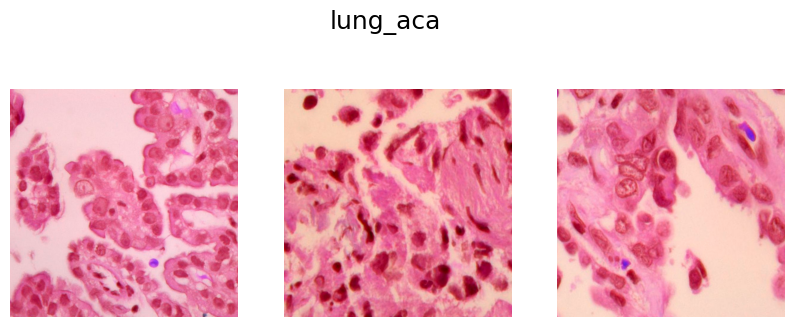

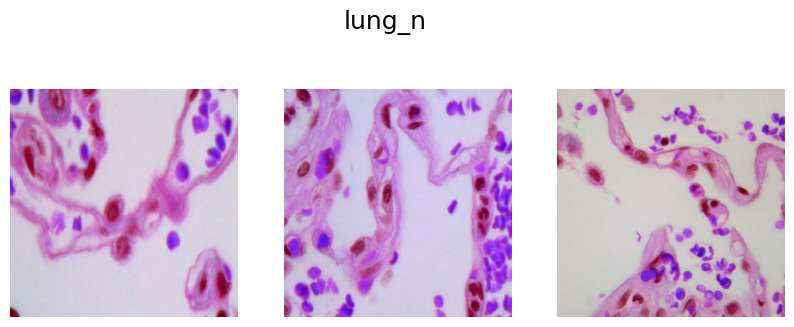

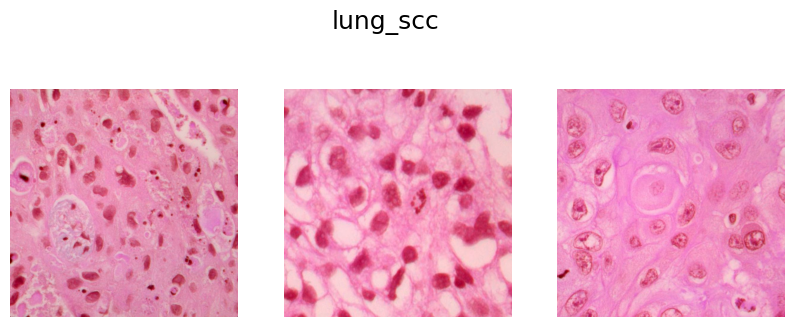

In [ ]:
# Itera a través de cada categoría definida en la lista CATEGORIES.
for category in CATEGORIES:
    # Construye la ruta completa al directorio de la categoría actual.
    path = os.path.join(DATADIR, category)
    # Obtiene una lista de todos los archivos dentro del directorio de la categoría actual.
    images = os.listdir(path)

    # Crea una figura y un conjunto de subtramas (ejes) para mostrar las imágenes.
    # En este caso, se crea una fila y tres columnas para mostrar 3 imágenes por categoría.
    fig, ax = plt.subplots(1, 3, figsize=(10, 4))
    # Establece un título principal para la figura, mostrando el nombre de la categoría.
    fig.suptitle(f'{category}', fontsize=18)

    # Itera tres veces para seleccionar y mostrar 3 imágenes por categoría.
    for i in range(3):
        # Selecciona aleatoriamente el nombre de un archivo de imagen de la lista 'images'.
        img_name = images[np.random.randint(0, len(images))]
        # Construye la ruta completa al archivo de imagen seleccionado.
        img_path = os.path.join(path, img_name)
        # Verifica si la extensión del archivo es una extensión de imagen común.
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
            # Lee la imagen utilizando OpenCV (cv2.imread).
            img_array = cv2.imread(img_path)
            # Verifica si la imagen se cargó correctamente (si img_array no es None).
            if img_array is not None:
                # Muestra la imagen en la subtrama actual (ax[i]).
                ax[i].imshow(img_array)
                # Desactiva los ejes (etiquetas y ticks) para una mejor visualización de la imagen.
                ax[i].axis('off')
            else:
                # Imprime una advertencia si no se pudo leer el archivo de imagen.
                print(f"Warning: Could not read image file: {img_path}")
        else:
            # Imprime un mensaje si el archivo no es un tipo de imagen reconocido y se omite.
            print(f"Skipping non-image file: {img_path}")

# Muestra todas las figuras creadas (una por categoría).
plt.show()

# Explicación:
Recorre cada categoría (lung_aca, lung_n, lung_scc).

Selecciona 3 imágenes aleatorias de cada categoría.

Verifica que sean archivos de imagen válidos (.png, .jpg, etc.).

Muestra las imágenes usando matplotlib.pyplot:

fig, ax = plt.subplots(1, 3, figsize=(10, 4)): Crea una figura con 3 subplots.

ax[i].imshow(img_array): Muestra la imagen en el subplot correspondiente.

ax[i].axis('off'): Oculta los ejes para mejor visualización.

Manejo de errores:

Si no puede leer una imagen, muestra un warning.

Omite archivos que no son imágenes.

Este fragmento de código tiene como objetivo visualizar ejemplos de imágenes de cada categoría en el conjunto de datos. Itera sobre cada categoría definida en CATEGORIES. Para cada categoría, construye la ruta a su directorio y lista todos los archivos que contiene. Luego, crea una figura con tres subtramas (espacios para mostrar imágenes) y le asigna un título con el nombre de la categoría. Dentro de un bucle, selecciona aleatoriamente tres nombres de archivo de imagen de la lista, construye la ruta completa a cada archivo y verifica si la extensión del archivo corresponde a un formato de imagen común. Si es una imagen, la lee usando OpenCV (cv2.imread), la muestra en una de las subtramas y desactiva los ejes para una visualización más limpia. Si no se puede leer la imagen o el archivo no es una imagen reconocida, se imprime una advertencia o un mensaje. Finalmente, después de procesar todas las categorías, se llama a plt.show() para mostrar todas las figuras con las imágenes seleccionadas.

# 6. Dataset Personalizado (Implementación Completa)

In [ ]:
# Define una clase personalizada llamada LungCancerDataset que hereda de la clase Dataset de PyTorch.
# Esta clase se utilizará para cargar y preprocesar las imágenes del conjunto de datos.
class LungCancerDataset(Dataset):

    # Constructor de la clase. Se ejecuta cuando se crea una instancia de LungCancerDataset.
    # root_dir: Directorio raíz donde se encuentran las carpetas de categorías.
    # categories: Lista de nombres de las categorías (por ejemplo, ['lung_aca', 'lung_n', 'lung_scc']).
    # transform: Transformaciones a aplicar a las imágenes (opcional).
    def __init__(self, root_dir, categories, transform=None):
        # Inicializa una lista vacía para almacenar las rutas de los archivos de imagen.
        self.data = []
        # Inicializa una lista vacía para almacenar las etiquetas de las imágenes.
        self.labels = []
        # Almacena las transformaciones que se aplicarán a las imágenes.
        self.transform = transform

        # Itera a través de cada categoría y su índice.
        for idx, category in enumerate(categories):
            # Construye la ruta completa a la carpeta de la categoría actual.
            folder = os.path.join(root_dir, category)
            # Itera a través de cada archivo en la carpeta de la categoría actual.
            for file in os.listdir(folder):
                # Añade la ruta completa del archivo de imagen a la lista de datos.
                self.data.append(os.path.join(folder, file))
                # Añade el índice de la categoría como etiqueta para esta imagen.
                self.labels.append(idx)

    # Método requerido por la clase Dataset. Devuelve el número total de muestras en el dataset.
    def __len__(self):
        return len(self.data)

    # Método requerido por la clase Dataset. Devuelve una muestra (imagen y etiqueta) dado un índice.
    def __getitem__(self, idx):
        # Obtiene la ruta del archivo de imagen en el índice especificado.
        img_path = self.data[idx]
        # Obtiene la etiqueta correspondiente al índice especificado.
        label = self.labels[idx]
        # Abre la imagen desde la ruta del archivo y la convierte al espacio de color RGB.
        image = Image.open(img_path).convert("RGB")
        # Aplica las transformaciones si se proporcionaron.
        if self.transform:
            image = self.transform(image)
        # Devuelve la imagen transformada y su etiqueta.
        return image, label

# Explicación:

Este código define una clase LungCancerDataset personalizada que se utiliza para cargar y preparar los datos de imágenes para el entrenamiento de un modelo de PyTorch. La clase hereda de torch.utils.data.Dataset y tiene tres métodos principales: __init__, __len__, y __getitem__.

* __init__: Este método constructor inicializa la clase leyendo todas las rutas
de los archivos de imagen desde las carpetas especificadas por root_dir y categories. Asigna una etiqueta numérica a cada imagen basada en la carpeta de la categoría a la que pertenece. También almacena cualquier transformación de imagen que se haya proporcionado.

* __len__: Este método devuelve el número total de imágenes en el conjunto de datos, que es simplemente el número de rutas de archivo almacenadas.

* __getitem__: Este método es fundamental para cargar los datos. Dado un índice, recupera la ruta de la imagen y su etiqueta correspondiente. Abre la imagen, la convierte a formato RGB y aplica las transformaciones especificadas antes de devolver la imagen preprocesada y su etiqueta.

En resumen, esta clase actúa como una interfaz para acceder a las imágenes y etiquetas del conjunto de datos de cáncer de pulmón e implementa la lógica necesaria para cargar y, opcionalmente, transformar las imágenes de manera que sean compatibles con los DataLoader y los modelos de PyTorch.

# 7. Transformaciones para datos de entrenamiento

In [ ]:
# Crea una secuencia de transformaciones de imagen utilizando transforms.Compose de torchvision.
# transforms.Compose aplica una lista de transformaciones en orden.
transform = transforms.Compose([
    # Redimensiona la imagen al tamaño especificado por IMG_SIZExIMG_SIZE.
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    # Aplica una inversión horizontal aleatoria a la imagen con una probabilidad del 50%.
    transforms.RandomHorizontalFlip(),
    # Rota la imagen aleatoriamente dentro de un rango de -15 a +15 grados.
    transforms.RandomRotation(15),
    # Recorta la imagen aleatoriamente y la redimensiona al tamaño especificado (IMG_SIZE).
    # La escala de recorte varía entre 0.85 y 1.0 del área original de la imagen.
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0)),
    # Convierte la imagen PIL a un tensor de PyTorch y escala los valores de píxel a un rango de [0, 1].
    transforms.ToTensor(),
])

# Explicación:

Este fragmento de código define una secuencia de transformaciones que se aplicarán a las imágenes antes de ser utilizadas para el entrenamiento del modelo. Utiliza torchvision.transforms.Compose para encadenar varias transformaciones comunes en un orden específico. Primero, redimensiona la imagen al tamaño especificado por IMG_SIZE. Luego, aplica transformaciones de aumento de datos aleatorias para mejorar la robustez del modelo: una inversión horizontal aleatoria, una rotación aleatoria dentro de un rango de 15 grados y un recorte redimensionado aleatorio que toma una porción aleatoria de la imagen original y la redimensiona al tamaño deseado. Finalmente, convierte la imagen procesada a un tensor de PyTorch, lo cual es necesario para alimentar el modelo. Estas transformaciones ayudan a variar el conjunto de entrenamiento, haciendo que el modelo sea menos propenso al sobreajuste y mejorando su capacidad de generalización.

# 8. Lista el contenido del directorio especificado

In [ ]:
# Ejecuta un comando de shell para listar el contenido del directorio especificado.
# La ruta apunta al directorio que contiene las carpetas de categorías de imágenes de pulmón
# dentro del conjunto de datos descargado en Colab.
# Esto es útil para verificar que el conjunto de datos se ha descargado correctamente
# y para ver los nombres de las subcarpetas (categorías).
!ls /content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/

lung_aca  lung_n  lung_scc


# Explicación:

Este fragmento de código ejecuta un comando de shell dentro del entorno de Colab. El comando ls se utiliza en sistemas basados en Unix (como el que subyace a Colab) para listar el contenido de un directorio. En este caso, el directorio especificado es /content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/. Al ejecutar esta celda, verás en la salida los nombres de los directorios y archivos que se encuentran directamente dentro de esa ruta. Esto se utiliza típicamente para verificar que el conjunto de datos se descargó correctamente y para confirmar los nombres exactos de las carpetas que contienen las imágenes de las diferentes categorías de cáncer de pulmón (lung_aca, lung_n, lung_scc), lo cual es crucial para la siguiente etapa donde se construye el Dataset.

# 9. Preparacion de Datos

In [ ]:
# Crea una instancia de la clase LungCancerDataset.
# Le pasa el directorio raíz (DATADIR), la lista de categorías (CATEGORIES)
# y las transformaciones definidas previamente (transform).
# Esta línea carga las rutas de las imágenes y sus etiquetas correspondientes.
dataset = LungCancerDataset(DATADIR, CATEGORIES, transform=transform)

# Calcula el tamaño del conjunto de entrenamiento, que es el 80% del total del dataset.
# Se convierte a entero para asegurar que sea un número de muestras válido.
train_size = int(0.8 * len(dataset))

# Calcula el tamaño del conjunto de prueba, que es el resto de las muestras (20%).
test_size = len(dataset) - train_size

# Divide el dataset original en dos subconjuntos: entrenamiento y prueba.
# random_split divide el dataset aleatoriamente basándose en los tamaños proporcionados.
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Crea un DataLoader para el conjunto de entrenamiento.
# DataLoader itera sobre el dataset en mini-lotes.
# batch_size especifica el número de imágenes por lote.
# shuffle=True mezcla los datos en cada época, lo que es importante para el entrenamiento.
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Crea un DataLoader para el conjunto de prueba.
# batch_size especifica el número de imágenes por lote.
# shuffle=False porque no es necesario mezclar los datos durante la evaluación.
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Explicación:

Este bloque de código se encarga de configurar el modelo para el entrenamiento utilizando la técnica de Transfer Learning. Primero, determina si hay una GPU disponible y establece el device (cuda o cpu) en consecuencia. Luego, carga un modelo ResNet50 preentrenado en el gran conjunto de datos ImageNet. La estrategia aquí es aprovechar el conocimiento que el modelo ha aprendido sobre la detección de características visuales generales en ImageNet. Inicialmente, "congela" todas las capas del modelo preentrenado estableciendo requires_grad en False, lo que significa que sus pesos no se modificarán durante la fase inicial del entrenamiento. La capa final (la capa completamente conectada que clasifica imágenes en ImageNet) se reemplaza por una nueva secuencia de capas (una capa lineal, una activación ReLU, Dropout y otra capa lineal con la salida igual al número de clases del problema actual). Esto se hace para adaptar el modelo a la tarea específica de clasificar imágenes de cáncer de pulmón con 3 clases. Finalmente, el modelo modificado se mueve al dispositivo seleccionado (GPU si está disponible) para acelerar el entrenamiento.

# 10. Configuarcion del modelo Resnet50

In [3]:
# Carga el modelo ResNet50 pre-entrenado en ImageNet y lo asigna a la variable d_cancerv1.
d_cancerv1 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 97.8MB/s]


In [ ]:
# Configura el dispositivo donde se ejecutará el modelo.
# Si hay una GPU disponible ("cuda"), utiliza la GPU; de lo contrario, utiliza la CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Itera a través de todos los parámetros (pesos y sesgos) del modelo.
# Congela todas las capas estableciendo requires_grad en False.
# Esto significa que los gradientes para estos parámetros no se calcularán
# durante la retropropagación, y sus valores no se actualizarán.
for param in d_cancerv1.parameters():
    param.requires_grad = False

# Reemplaza la capa completamente conectada final (el "head" o clasificador) de ResNet50.
# La capa original está diseñada para 1000 clases (ImageNet).
# Se reemplaza por una nueva secuencia de capas para adaptarla a 3 clases (tipos de cáncer de pulmón).
d_cancerv1.fc = nn.Sequential(
    # Añade una capa lineal (totalmente conectada) que toma la salida de la capa anterior
    # (d_cancerv1.fc.in_features) y la mapea a 512 características.
    nn.Linear(d_cancerv1.fc.in_features, 512),
    # Añade una función de activación ReLU (Rectified Linear Unit) después de la capa lineal.
    nn.ReLU(),
    # Añade una capa de Dropout con una probabilidad de 0.5.
    # Esto desactiva aleatoriamente neuronas durante el entrenamiento para prevenir el sobreajuste.
    nn.Dropout(0.5),
    # Añade otra capa lineal que toma las 512 características y las mapea al número de clases (NUM_CLASSES).
    nn.Linear(512, NUM_CLASSES)
)

# Mueve el modelo 'd_cancerv1' al dispositivo especificado por la variable 'device'.
# 'device' fue previamente configurado para ser la GPU si está disponible, o la CPU si no.
# Esto asegura que las operaciones del modelo se realicen en el hardware seleccionado
# para potencialmente acelerar el entrenamiento y la inferencia.
# La función .to(device) se utiliza para mover todos los submódulos, parámetros y buffers
# del módulo a la ubicación especificada.
d_cancerv1 = d_cancerv1.to(device)

# Explicacion:

Este bloque de código se encarga de configurar el modelo para el entrenamiento utilizando la técnica de Transfer Learning.

Primero, determina si hay una GPU disponible y establece el device (cuda o cpu) en consecuencia. Luego, carga un modelo ResNet50 preentrenado en el gran conjunto de datos ImageNet. La estrategia aquí es aprovechar el conocimiento que el modelo ha aprendido sobre la detección de características visuales generales en ImageNet.

Inicialmente, "congela" todas las capas del modelo preentrenado estableciendo requires_grad en False, lo que significa que sus pesos no se modificarán durante la fase inicial del entrenamiento. La capa final (la capa completamente conectada que clasifica imágenes en ImageNet) se reemplaza por una nueva secuencia de capas (una capa lineal, una activación ReLU, Dropout y otra capa lineal con la salida igual al número de clases del problema actual). Esto se hace para adaptar el modelo a la tarea específica de clasificar imágenes de cáncer de pulmón con 3 clases.

Finalmente, garantiza que el modelo neuronal, d_cancerv1, se cargue en el dispositivo computacional seleccionado, que en este caso es la GPU si está disponible, o la CPU en su defecto. Al llamar al método .to(device) en el modelo, todos los pesos y parámetros del modelo se transfieren a la memoria de la GPU (o se mantienen en la CPU). Esto es fundamental porque tanto los datos de entrada (imágenes y etiquetas) como el modelo deben residir en el mismo dispositivo para que las operaciones de cálculo (como la pasada hacia adelante y la retropropagación) puedan realizarse de manera eficiente. Realizar estas operaciones en la GPU cuando está disponible acelera significativamente el proceso de entrenamiento, especialmente con modelos grandes y conjuntos de datos extensos.

# 11. Conficuracion y entrenamiento inicial

In [ ]:
# Define la función de pérdida que se utilizará para medir qué tan bien se desempeña el modelo.
# CrossEntropyLoss es común para problemas de clasificación multiclase.
criterion = nn.CrossEntropyLoss()

# Define el optimizador que actualizará los pesos del modelo durante el entrenamiento.
# optim.Adam es un algoritmo de optimización popular y efectivo.
# d_cancerv1.fc.parameters() especifica que SÓLO se optimizarán los parámetros de la capa final (el "head")
# que reemplazamos previamente. Las otras capas están congeladas y no se actualizarán en esta etapa.
# lr=0.001 establece la tasa de aprendizaje inicial para el optimizador.
optimizer = optim.Adam(d_cancerv1.fc.parameters(), lr=0.001)

# Imprime un mensaje para indicar el inicio de la fase de entrenamiento inicial (solo la cabeza).
print("Entrenamiento inicial-solo cabeza")

# Inicia el bucle de entrenamiento para un número específico de épocas (en este caso, 3 épocas).
# Una época es una pasada completa a través de todo el conjunto de datos de entrenamiento.
for epoch in range(3):
    # Establece el modelo en modo de entrenamiento. Esto habilita funcionalidades como Dropout y Batch Normalization.
    d_cancerv1.train()
    # Inicializa una variable para acumular la pérdida total en la época actual.
    total_loss = 0
    # Itera sobre el DataLoader de entrenamiento, obteniendo mini-lotes de imágenes y etiquetas.
    for images, labels in train_loader:
        # Mueve el lote de imágenes y etiquetas al dispositivo configurado (GPU o CPU).
        images, labels = images.to(device), labels.to(device)

        # Limpia los gradientes acumulados de la iteración anterior. Es necesario antes de calcular nuevos gradientes.
        optimizer.zero_grad()

        # Realiza una pasada hacia adelante (forward pass) del modelo.
        # Pasa las imágenes a través del modelo para obtener las predicciones (salidas).
        outputs = d_cancerv1(images)

        # Calcula la pérdida comparando las predicciones del modelo con las etiquetas reales.
        loss = criterion(outputs, labels)

        # Realiza la retropropagación (backward pass).
        # Calcula los gradientes de la pérdida con respecto a los parámetros entrenables (solo la cabeza en esta etapa).
        loss.backward()

        # Actualiza los pesos de los parámetros entrenables utilizando los gradientes calculados por el optimizador.
        optimizer.step()

        # Suma la pérdida del lote actual a la pérdida total de la época.
        total_loss += loss.item()

    # Imprime la pérdida promedio de la época al finalizar cada época.
    # total_loss / len(train_loader) calcula la pérdida promedio por lote.
    print(f"Epoch {epoch+1} - Loss: {total_loss / len(train_loader):.4f}")

Entrenamiento inicial-solo cabeza
Epoch 1 - Loss: 0.2721
Epoch 2 - Loss: 0.1912
Epoch 3 - Loss: 0.1849


# Explicación:

Este bloque de código lleva a cabo la fase de entrenamiento inicial del modelo, centrándose únicamente en la capa clasificadora (el "head" o fc) que se agregó. Primero, define la función de pérdida (CrossEntropyLoss) que cuantifica la diferencia entre las predicciones del modelo y las etiquetas reales, lo cual es esencial para guiar el entrenamiento. Luego, configura el optimizador (Adam), especificando que solo debe actualizar los parámetros de la capa final, ya que el resto de las capas están congeladas en este punto. El código entra en un bucle para entrenar durante un número fijo de épocas (3 en este caso). Dentro de cada época, itera sobre los mini-lotes de datos proporcionados por el train_loader. Para cada lote, las imágenes y etiquetas se mueven al dispositivo adecuado (GPU o CPU). Los gradientes anteriores se ponen a cero, se realiza una pasada hacia adelante a través del modelo para obtener las predicciones, se calcula la pérdida, se realiza la retropropagación para calcular los gradientes de la pérdida con respecto a los parámetros de la cabeza, y finalmente el optimizador actualiza estos parámetros. La pérdida de cada lote se acumula, y al final de cada época, se imprime la pérdida promedio por lote para monitorear el progreso del entrenamiento

# 12. Implementa la fase de "Fine-Tuning" del modelo

In [ ]:
# Itera a través de los parámetros nombrados del modelo (obteniendo el nombre y el parámetro).
for name, param in d_cancerv1.named_parameters():
    # Verifica si el nombre del parámetro contiene "layer4" o "fc".
    # "layer4" es una de las últimas capas convolucionales de ResNet50.
    # "fc" es la capa completamente conectada que reemplazamos (el "head").
    # Si el nombre coincide, establece requires_grad en True.
    # Esto "descongela" estas capas, permitiendo que sus gradientes se calculen
    # y sus pesos se actualicen durante la retropropagación en esta fase de entrenamiento.
    if "layer4" in name or "fc" in name:
        param.requires_grad = True

# Imprime un mensaje para indicar que se está configurando un nuevo optimizador.
# Nuevo optimizador con LR baja

# Crea un nuevo optimizador (optim.Adam) para esta fase de Fine-Tuning.
# Usa un filtro lambda para seleccionar SOLO los parámetros cuyo requires_grad es True.
# Esto asegura que solo las capas "descongeladas" (layer4 y fc) sean actualizadas por este optimizador.
# La tasa de aprendizaje (lr) se establece en un valor más bajo (1e-5) que en la fase inicial.
# Una tasa de aprendizaje más baja es típica en el Fine-Tuning para ajustar sutilmente los pesos preentrenados.
optimizer = optim.Adam(filter(lambda p: p.requires_grad, d_cancerv1.parameters()), lr=1e-5)

# Imprime un mensaje para indicar el inicio de la fase de Fine-Tuning.
print("Entrenamiento Fine-Tuning (últimas capas)")

# Inicia el bucle de entrenamiento para la fase de Fine-Tuning (en este caso, 5 épocas).
for epoch in range(5):
    # Establece el modelo en modo de entrenamiento.
    d_cancerv1.train()
    # Inicializa la pérdida total para la época actual.
    total_loss = 0
    # Itera sobre el DataLoader de entrenamiento.
    for images, labels in train_loader:
        # Mueve los datos al dispositivo configurado.
        images, labels = images.to(device), labels.to(device)

        # Limpia los gradientes acumulados.
        optimizer.zero_grad()

        # Realiza la pasada hacia adelante.
        outputs = d_cancerv1(images)

        # Calcula la pérdida.
        loss = criterion(outputs, labels)

        # Realiza la retropropagación. Los gradientes se calcularán ahora para layer4 y fc.
        loss.backward()

        # Actualiza los pesos de las capas "descongeladas".
        optimizer.step()

        # Suma la pérdida del lote.
        total_loss += loss.item()

    # Imprime la pérdida promedio de la época de Fine-Tuning.
    print(f"Epoch {epoch+1} - Loss: {total_loss / len(train_loader):.4f}")

Entrenamiento Fine-Tuning (últimas capas)
Epoch 1 - Loss: 0.1076
Epoch 2 - Loss: 0.0609
Epoch 3 - Loss: 0.0417
Epoch 4 - Loss: 0.0259
Epoch 5 - Loss: 0.0238


# Explicación:

Este bloque de código implementa la fase de "Fine-Tuning" del modelo. En esta etapa, se descongelan algunas de las últimas capas convolucionales preentrenadas del modelo ResNet50 (específicamente la capa layer4) además de la capa clasificadora (fc) que se entrenó inicialmente. Al establecer requires_grad en True para los parámetros de estas capas, se permite que sus pesos se actualicen durante la retropropagación. Se crea un nuevo optimizador con una tasa de aprendizaje significativamente más baja (1e-5) que en la fase inicial. Una tasa de aprendizaje baja es crucial en el Fine-Tuning para evitar la destrucción del conocimiento preentrenado y permitir solo ajustes finos a los pesos existentes. El bucle de entrenamiento es similar al de la fase inicial, pero ahora la retropropagación y la actualización de pesos afectan tanto a las capas layer4 como a la capa fc. El objetivo de esta fase es ajustar las últimas capas del modelo a las características específicas del conjunto de datos de cáncer de pulmón, aprovechando la capacidad de las capas convolucionales profundas para aprender representaciones de características de alto nivel. Se entrena durante 5 épocas y se monitorea la pérdida promedio por época

# 13. Evaluación final

In [ ]:
# Establece el modelo en modo de evaluación.
# Esto desactiva ciertas funcionalidades que solo son necesarias durante el entrenamiento,
# como Dropout y Batch Normalization en modo de entrenamiento.
# Es crucial hacer esto antes de la inferencia o evaluación para obtener resultados consistentes.
d_cancerv1.eval()

# Inicializa una lista vacía para almacenar todas las predicciones del modelo en el conjunto de prueba.
all_preds = []
# Inicializa una lista vacía para almacenar todas las etiquetas reales del conjunto de prueba.
all_labels = []

# Desactiva el cálculo de gradientes.
# Esto reduce el uso de memoria y acelera las computaciones, ya que no se necesitan gradientes
# durante la inferencia o evaluación.
with torch.no_grad():
    # Itera sobre el DataLoader del conjunto de prueba, obteniendo mini-lotes de imágenes y etiquetas.
    for images, labels in test_loader:
        # Mueve las imágenes al dispositivo configurado (GPU o CPU).
        # Las etiquetas se mantendrán en la CPU inicialmente para su posterior comparación.
        images = images.to(device)

        # Realiza una pasada hacia adelante (forward pass) del modelo.
        # Pasa las imágenes a través del modelo para obtener las predicciones sin calcular gradientes.
        outputs = d_cancerv1(images)

        # Obtiene la clase predicha para cada imagen en el lote.
        # torch.argmax(outputs, dim=1) encuentra el índice de la puntuación más alta en cada fila de las salidas.
        # .cpu() mueve el tensor de predicciones a la CPU.
        # .numpy() convierte el tensor a un array de NumPy.
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        # Añade las predicciones del lote actual a la lista general de predicciones.
        all_preds.extend(preds)
        # Añade las etiquetas reales del lote actual a la lista general de etiquetas.
        # .numpy() convierte el tensor de etiquetas a un array de NumPy.
        all_labels.extend(labels.numpy())

# Explicación:

Este bloque de código se dedica a evaluar el rendimiento del modelo entrenado en el conjunto de datos de prueba. Inicia poniendo el modelo en modo de evaluación (d_cancerv1.eval()), lo cual desactiva capas y funcionalidades específicas del entrenamiento como Dropout. Luego, crea listas vacías para almacenar todas las predicciones del modelo (all_preds) y las etiquetas reales (all_labels) del conjunto de prueba. La evaluación se realiza dentro de un contexto with torch.no_grad(), que desactiva el cálculo de gradientes, ahorrando memoria y tiempo de computación, ya que la retropropagación no es necesaria durante la inferencia. El código itera a través del test_loader para obtener mini-lotes de imágenes y etiquetas. Cada lote de imágenes se mueve al dispositivo configurado, se pasa por el modelo para obtener las salidas (puntuaciones de clase), y se obtiene la predicción final seleccionando el índice con la puntuación más alta (torch.argmax). Las predicciones (movidas a la CPU y convertidas a NumPy) y las etiquetas reales (convertidas a NumPy) se añaden a sus respectivas listas. Al final de este bloque, las listas all_preds y all_labels contendrán las predicciones del modelo y las etiquetas reales para todas las imágenes en el conjunto de prueba, listas para calcular métricas de evaluación

# 14. Reporte y matriz de confusión


Clasificación final:
              precision    recall  f1-score   support

    lung_aca       1.00      0.99      0.99      1005
      lung_n       1.00      1.00      1.00       967
    lung_scc       0.99      1.00      0.99      1028

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



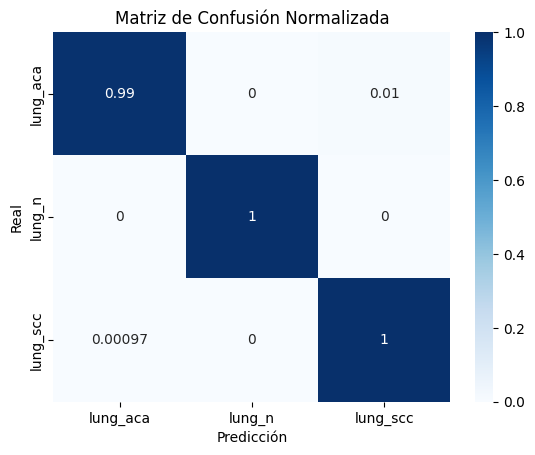

In [ ]:
# Imprime un encabezado para la sección de resultados de la clasificación final.
print("\nClasificación final:")

# Imprime un reporte de clasificación detallado.
# classification_report calcula métricas como precisión, recall, f1-score y soporte
# para cada clase.
# all_labels son las etiquetas reales del conjunto de prueba.
# all_preds son las predicciones del modelo para el conjunto de prueba.
# target_names=CATEGORIES proporciona los nombres de las clases para una salida más legible.
print(classification_report(all_labels, all_preds, target_names=CATEGORIES))

# Calcula la matriz de confusión.
# confusion_matrix crea una tabla que resume el rendimiento de un algoritmo de clasificación.
# Cada fila de la matriz representa las instancias en una clase real,
# mientras que cada columna representa las instancias en una clase predicha.
# normalize='true' normaliza la matriz dividiendo cada fila por el número total de muestras en esa clase real.
# Esto muestra las proporciones de predicciones correctas e incorrectas dentro de cada clase real.
cf = confusion_matrix(all_labels, all_preds, normalize='true')

# Crea un heatmap (mapa de calor) de la matriz de confusión utilizando Seaborn.
# sns.heatmap visualiza la matriz como un mapa de color.
# cf es la matriz de confusión calculada.
# annot=True muestra los valores numéricos en cada celda del heatmap.
# cmap='Blues' establece el esquema de color del heatmap.
# xticklabels=CATEGORIES establece las etiquetas del eje X (predicciones) con los nombres de las categorías.
# yticklabels=CATEGORIES establece las etiquetas del eje Y (real) con los nombres de las categorías.
sns.heatmap(cf, annot=True, cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)

# Establece la etiqueta del eje X del gráfico del heatmap como "Predicción".
plt.xlabel("Predicción")
# Establece la etiqueta del eje Y del gráfico del heatmap como "Real".
plt.ylabel("Real")
# Establece el título del gráfico del heatmap.
plt.title("Matriz de Confusión Normalizada")

# Muestra el gráfico del heatmap de la matriz de confusión.
plt.show()

# Explicación:

Este bloque de código tiene como objetivo presentar las métricas de evaluación del modelo de clasificación después de que se ha evaluado en el conjunto de prueba y se han recolectado todas las predicciones y etiquetas reales en las listas all_preds y all_labels. Primero, imprime un reporte de clasificación detallado utilizando classification_report. Este reporte muestra métricas clave como la precisión, el recall, el f1-score y el soporte para cada una de las clases (lung_aca, lung_n, lung_scc), proporcionando una visión completa del rendimiento del modelo por clase. Luego, calcula la matriz de confusión utilizando confusion_matrix. Esta matriz tabulariza el número (o proporción) de predicciones correctas e incorrectas para cada clase. Al normalizarla por fila (normalize='true'), muestra la proporción de veces que cada clase real fue predicha correctamente o incorrectamente como otra clase. Finalmente, utiliza la biblioteca seaborn para visualizar esta matriz de confusión normalizada como un mapa de calor (heatmap). La visualización incluye los valores numéricos en las celdas, las etiquetas de las clases en los ejes y un título, haciendo que sea fácil interpretar visualmente dónde el modelo está funcionando bien y dónde comete errores (confundiendo una clase con otra). La función plt.show() se llama para renderizar y mostrar este gráfico.

# 15. Guardar en checkpoint

In [ ]:
# Define una variable 'PATH' que especifica el nombre del archivo donde se guardará el checkpoint del modelo.
# En este caso, el archivo se llamará 'checkpoint.pt' y se guardará en el directorio actual ('.').
PATH = './checkpoint.pt'

# Guarda el estado interno del modelo (state_dict) en un archivo.
# torch.save() serializa un objeto (en este caso, el state_dict del modelo) en un archivo en el disco.
# d_cancerv1.state_dict() obtiene un diccionario que contiene todos los parámetros aprendidos del modelo.
# PATH especifica la ubicación y el nombre del archivo donde se guardará el state_dict.
# Guardar solo el state_dict es la forma recomendada en PyTorch para guardar modelos,
# ya que es más flexible para cargar el modelo en diferentes arquitecturas. [1, 2]
torch.save(d_cancerv1.state_dict(), PATH)

# Explicación:

Este breve fragmento de código se encarga de guardar los pesos y sesgos aprendidos del modelo entrenado. Primero, define una variable PATH que especifica la ruta y el nombre del archivo donde se almacenará la información del modelo, en este caso, un archivo llamado checkpoint.pt en el directorio actual. Luego, utiliza la función torch.save() para serializar y guardar el state_dict del modelo d_cancerv1 en ese archivo. El state_dict es un diccionario de Python que contiene el estado persistente del modelo, incluyendo todos los parámetros del modelo (como pesos y sesgos) y búferes no persistentes. Guardar solo el state_dict es una práctica común en PyTorch, ya que permite cargar los pesos en diferentes arquitecturas de modelo, lo cual es útil para la transfer learning o para modelos con modificaciones. En esencia, este código crea un "checkpoint" del modelo entrenado en el disco, permitiendo su posterior carga y reutilización sin necesidad de reentrenar.

# 16. Guardar en modelo

In [ ]:
# Guarda el modelo completo (incluyendo la arquitectura y los pesos) en un archivo.
# torch.save() serializa el objeto del modelo completo en un archivo.
# d_cancerv1 es la instancia del modelo que se va a guardar.
# 'd_cancerv1.pt' es el nombre del archivo donde se guardará el modelo serializado.
# Este método guarda tanto la definición del modelo como los parámetros aprendidos. [1]
# Si bien es útil para guardar y cargar el modelo rápidamente, puede ser menos flexible
# que guardar solo el state_dict, especialmente si la arquitectura del modelo original
# no está disponible al cargar.
torch.save(d_cancerv1, 'd_cancerv1.pt')

# Explicación:

Este fragmento de código guarda el modelo completo, incluyendo su arquitectura y todos sus parámetros aprendidos, en un archivo llamado d_cancerv1.pt. A diferencia del método anterior que solo guardaba el state_dict (los pesos y sesgos), esta función torch.save() serializa la instancia completa del objeto modelo. Esto significa que al cargar el modelo más tarde, no necesitarás tener la definición de la clase del modelo original disponible explícitamente, ya que está incluida en el archivo guardado. Si bien esto puede ser conveniente para guardar y cargar rápidamente el modelo, puede ser menos flexible si planeas usar los pesos en una arquitectura de modelo ligeramente modificada o si la estructura exacta de la clase original no está garantizada al cargar. Esencialmente, crea un "archivo de modelo" completo que contiene todo lo necesario para reconstruir y utilizar el modelo entrenado.

# 17. Cargar checkpoint

In [ ]:
# Carga el state_dict (los pesos y sesgos) guardado previamente desde el archivo especificado por PATH.
# torch.load(PATH) carga el objeto serializado desde el archivo 'checkpoint.pt'.
# d_cancerv1.load_state_dict() carga este diccionario de estado cargado en la instancia actual del modelo 'd_cancerv1'.
# Esto sobrescribe los parámetros actuales del modelo con los parámetros guardados. [1]
# Es importante asegurarse de que la arquitectura del modelo 'd_cancerv1' sea compatible con el state_dict que se está cargando.
d_cancerv1.load_state_dict(torch.load(PATH))

# Establece el modelo en modo de evaluación.
# Esto es crucial después de cargar un modelo guardado si planeas realizar inferencia o evaluación.
# Asegura que capas como Dropout y Batch Normalization se comporten correctamente durante la evaluación. [1]
d_cancerv1.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Explicación:

Este fragmento de código se utiliza para cargar un modelo entrenado previamente a partir de un archivo de checkpoint. La primera línea utiliza torch.load(PATH) para leer el state_dict (el diccionario que contiene los pesos y sesgos del modelo) desde el archivo especificado por la variable PATH (que apunta a 'checkpoint.pt'). Luego, d_cancerv1.load_state_dict() toma este state_dict cargado y lo aplica a la instancia actual del modelo d_cancerv1, actualizando así sus parámetros a los valores guardados. Esto efectivamente restaura el modelo a su estado en el momento en que se guardó el checkpoint. La segunda línea, d_cancerv1.eval(), es fundamental y pone el modelo en modo de evaluación. Esto deshabilita funcionalidades específicas del entrenamiento como Dropout y asegura que las capas como Batch Normalization utilicen estadísticas acumuladas en lugar de estadísticas de lote, lo cual es necesario para obtener resultados consistentes y fiables durante la inferencia o la evaluación en el conjunto de prueba. En conjunto, estas líneas permiten cargar un modelo entrenado y prepararlo para su uso en la predicción o la evaluación.

# 17. Evaluar el checkpoint cargado

In [ ]:
# Importa la biblioteca tqdm, que se utiliza para mostrar barras de progreso.
from tqdm import tqdm

# Define una función llamada 'evaluate' que toma el modelo y un DataLoader como entrada.
# Esta función está diseñada para calcular la precisión del modelo en un conjunto de datos.
# Modify the evaluate function to accept a single dataloader
def evaluate(d_cancerv1, dataloader):
    # Establece el modelo en modo de evaluación.
    d_cancerv1.eval()
    # Asegura que el modelo esté en el dispositivo correcto (GPU/CPU).
    d_cancerv1.to(device)
    # Use the dataloader directly, not as a dictionary key

    # Envuelve el dataloader con tqdm para mostrar una barra de progreso durante la iteración.
    bar = tqdm(dataloader)
    # Inicializa una lista vacía para almacenar la precisión de cada lote.
    acc = []
    # Desactiva el cálculo de gradientes para la inferencia.
    with torch.no_grad():
        # Itera sobre los lotes del dataloader, mostrando la barra de progreso.
        for batch in bar:
            # Desempaqueta el lote en imágenes (X) y etiquetas (y).
            X, y = batch
            # Mueve las imágenes y etiquetas al dispositivo configurado.
            X, y = X.to(device), y.to(device)
            # Realiza una pasada hacia adelante para obtener las predicciones del modelo.
            y_hat = d_cancerv1(X)
            # Calcula la precisión del lote actual.
            # (y == torch.argmax(y_hat, axis=1)) compara las etiquetas reales con las predicciones (índice de la clase con mayor puntuación).
            # .sum().item() cuenta el número de predicciones correctas en el lote y lo convierte a un escalar Python.
            # / len(y) divide el número de predicciones correctas por el tamaño del lote para obtener la precisión del lote.
            acc.append((y == torch.argmax(y_hat, axis=1)).sum().item() / len(y))
            # Actualiza la descripción de la barra de progreso para mostrar la precisión promedio actual.
            bar.set_description(f"acc {np.mean(acc):.5f}")

# Llama a la función evaluate, pasando el modelo y el dataloader de prueba.
# Esto iniciará la evaluación del modelo en el conjunto de prueba y mostrará la barra de progreso con la precisión.
# Call the evaluate function with the test_loader
evaluate(d_cancerv1, test_loader)

acc 0.99701: 100%|██████████| 94/94 [00:35<00:00,  2.62it/s]


# Explicación:

Este bloque de código define y ejecuta una función para evaluar el rendimiento del modelo en un conjunto de datos utilizando un DataLoader. Importa la biblioteca tqdm para visualizar el progreso. La función evaluate toma el modelo (d_cancerv1) y un dataloader como entrada. Dentro de la función, el modelo se establece en modo de evaluación (d_cancerv1.eval()) y se asegura de que esté en el dispositivo correcto. Luego, itera sobre los lotes proporcionados por el dataloader, utilizando tqdm para mostrar una barra de progreso en tiempo real. Para cada lote, desactiva el cálculo de gradientes (with torch.no_grad()) y mueve las imágenes y etiquetas al dispositivo adecuado. Realiza una pasada hacia adelante a través del modelo para obtener las predicciones, determina la clase predicha para cada imagen seleccionando el índice de la puntuación más alta, calcula la precisión para ese lote comparando las predicciones con las etiquetas reales y almacena esta precisión. La descripción de la barra de progreso se actualiza dinámicamente para mostrar la precisión promedio calculada hasta el momento. Finalmente, se llama a esta función evaluate pasando el modelo y el test_loader para iniciar la evaluación en el conjunto de datos de prueba

Nuevo entrenamiento del Modelo


Reporte de Clasificación para el checkpoint cargado:


acc 0.99701: 100%|██████████| 94/94 [00:36<00:00,  2.57it/s]


              precision    recall  f1-score   support

    lung_aca       1.00      0.99      1.00      1005
      lung_n       1.00      1.00      1.00       967
    lung_scc       0.99      1.00      1.00      1028

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



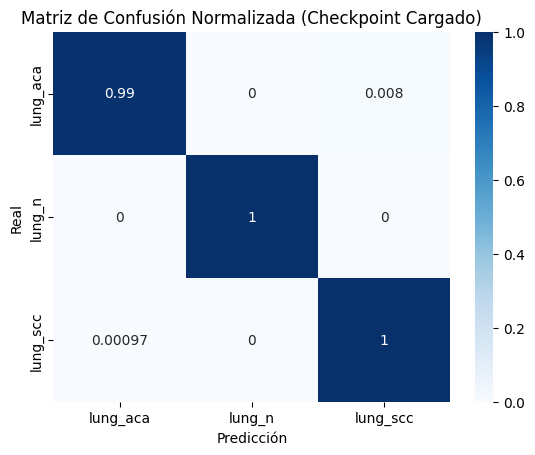

In [ ]:
# prompt: Evaluar las metricas para  cargado para d_cancerv1 de todas las categorias existentes

import matplotlib.pyplot as plt
# 17. Evaluar el checkpoint cargado
# Importa la biblioteca tqdm, que se utiliza para mostrar barras de progreso.
from tqdm import tqdm
import numpy as np # Asegura que numpy esté importado para np.mean
import torch # Asegura que torch esté importado

# Opcional: Calcular y mostrar el reporte de clasificación y la matriz de confusión
# Si deseas ver el reporte de clasificación y la matriz de confusión para el modelo cargado,
# puedes repetir el código del paso 14.
# Asegúrate de que all_labels y all_preds se recalculen si es necesario,
# o si la función evaluate ya los está recolectando, úsalos aquí.

print("\nReporte de Clasificación para el checkpoint cargado:")

# Para obtener el classification_report y la confusion_matrix,
# necesitas recolectar todas las predicciones y etiquetas nuevamente
# durante la evaluación. Modificamos la función evaluate para hacerlo.

def evaluate_and_collect_metrics(d_cancerv1, dataloader):
    d_cancerv1.eval()
    d_cancerv1.to(device)

    all_preds = []
    all_labels = []

    bar = tqdm(dataloader)
    acc = []

    with torch.no_grad():
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)

            y_hat = d_cancerv1(X)

            preds = torch.argmax(y_hat, dim=1).cpu().numpy()
            labels_np = y.cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels_np)

            acc.append((y == torch.argmax(y_hat, axis=1)).sum().item() / len(y))
            bar.set_description(f"acc {np.mean(acc):.5f}")

    return all_labels, all_preds

# Vuelve a evaluar el conjunto de prueba para recolectar las predicciones y etiquetas
all_labels_loaded, all_preds_loaded = evaluate_and_collect_metrics(d_cancerv1, test_loader)

# Imprime el reporte de clasificación detallado
print(classification_report(all_labels_loaded, all_preds_loaded, target_names=CATEGORIES))

# Calcula la matriz de confusión normalizada
cf_loaded = confusion_matrix(all_labels_loaded, all_preds_loaded, normalize='true')

# Crea y muestra el heatmap de la matriz de confusión
plt.figure() # Crea una nueva figura para el heatmap
sns.heatmap(cf_loaded, annot=True, cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión Normalizada (Checkpoint Cargado)")
plt.show()



In [ ]:
import matplotlib.pyplot as plt  # Para crear las gráficas
import torch  # Biblioteca para computación con tensores y entrenamiento de modelos

# Función generalizada para entrenar el modelo durante un número de épocas
def train_model(model, loader, optimizer, criterion, device, epochs, phase):
    model.train()  # Establece el modelo en modo entrenamiento (activa dropout, batchnorm, etc.)
    losses, accuracies = [], []  # Listas para guardar pérdida y precisión por época

    print(f"\nEntrenamiento: {phase} ({epochs} épocas)")  # Mensaje indicando fase y número de épocas
    for epoch in range(1, epochs + 1):  # Bucle de entrenamiento por época
        total_loss, correct, total = 0, 0, 0  # Inicializa métricas acumulativas

        for images, labels in loader:  # Itera sobre los batches del DataLoader
            images, labels = images.to(device), labels.to(device)  # Mueve datos a GPU o CPU

            optimizer.zero_grad()  # Reinicia los gradientes del optimizador
            outputs = model(images)  # Hace predicción (forward pass)
            loss = criterion(outputs, labels)  # Calcula la pérdida (error) entre predicción y verdad
            loss.backward()  # Backpropagation: calcula gradientes
            optimizer.step()  # Actualiza los pesos del modelo con los gradientes

            total_loss += loss.item()  # Suma la pérdida del batch a la pérdida total
            _, preds = torch.max(outputs, 1)  # Obtiene las clases predichas con mayor probabilidad
            total += labels.size(0)  # Cuenta cuántos ejemplos se han procesado
            correct += (preds == labels).sum().item()  # Cuenta cuántas predicciones fueron correctas

        avg_loss = total_loss / len(loader)  # Calcula pérdida promedio por época
        accuracy = correct / total if total else 0  # Calcula precisión de la época
        losses.append(avg_loss)  # Guarda la pérdida promedio
        accuracies.append(accuracy)  # Guarda la precisión

        # Imprime resumen de la época
        print(f"Época {epoch}: Pérdida = {avg_loss:.4f}, Precisión = {accuracy:.4f}")

    return losses, accuracies  # Devuelve métricas de entrenamiento

# --- Entrenamiento Inicial (solo cabeza de red) ---
epochs_initial = 3  # Número de épocas para la fase inicial
train_losses, train_accuracies = train_model(
    d_cancerv1,  # Modelo a entrenar
    train_loader,  # DataLoader con los datos de entrenamiento
    optimizer,  # Optimizador configurado previamente
    criterion,  # Función de pérdida (por ejemplo, CrossEntropyLoss)
    device,  # CPU o GPU
    epochs_initial,  # Número de épocas
    phase="Inicial (solo cabeza)"  # Nombre de la fase para mostrar en consola
)

# --- Fine-Tuning (ajuste fino del modelo completo) ---
# Asegúrate de haber descongelado capas y ajustado el optimizador aquí antes
epochs_finetune = 5  # Número de épocas para fine-tuning
finetune_losses, finetune_accuracies = train_model(
    d_cancerv1,
    train_loader,
    optimizer,
    criterion,
    device,
    epochs_finetune,
    phase="Fine-Tuning"
)

In [ ]:
# Graficar la pérdida y la precisión de entrenamiento por época (separado por fases)
plt.figure(figsize=(12, 5))

# Gráfica de Pérdida
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Inicial')
plt.plot(range(len(train_losses) + 1, len(train_losses) + len(finetune_losses) + 1), finetune_losses, label='Fine-Tuning')
plt.title('Pérdida de Entrenamiento por Época')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de Precisión
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Inicial')
plt.plot(range(len(train_accuracies) + 1, len(train_accuracies) + len(finetune_accuracies) + 1), finetune_accuracies, label='Fine-Tuning')
plt.title('Precisión de Entrenamiento por Época')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()

# Guardar la ultima version

In [ ]:
torch.save(d_cancerv1, 'd_cancerv2.pt')